In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')

In [2]:
from omegaconf import OmegaConf
import torch
import segmentation_models_pytorch as smp
from torch import nn
from pytorch_lightning.logging import TensorBoardLogger
from dl.lightning_model import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/usr/l

In [3]:
model = smp.FPN(encoder_name="resnext50_32x4d", classes=2, decoder_merge_policy='cat')
# class_weight = dataset["train"].numpixels[1,0:2]
# class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor')

criterion = nn.CrossEntropyLoss(
    ignore_index = -100,
    reduction = 'none'
)

In [4]:
conf = OmegaConf.create(
    {   
        'result_model_dir':"../../../../results/trained_models/tests/",
        'logdir':"../../../../results/tensorboard_logs/tests/",
        'model_name':'FPN',
        'experiment_version':'test5',
        
        'dataloader_args': {
            'batch_size':6,
            'n_classes':2
        },
        
        'optimizer_args':{
            'lr':0.001,
            'encoder_lr':0.0005,
            'weight_decay':0.0003,
            'encoder_weight_decay':0.00003
        },
        
        'scheduler_args': {
            'factor':0.25,
            'patience':2
        },
    
        'loss_args' : {
            'edge_weight' : 1.1,
        }

    }
)
print(conf.pretty())

result_model_dir: ../../../../results/trained_models/tests/
logdir: ../../../../results/tensorboard_logs/tests/
model_name: FPN
experiment_version: test5
dataloader_args:
  batch_size: 6
  n_classes: 2
optimizer_args:
  lr: 0.001
  encoder_lr: 0.0005
  weight_decay: 0.0003
  encoder_weight_decay: 3.0e-05
scheduler_args:
  factor: 0.25
  patience: 2
loss_args:
  edge_weight: 1.1



In [5]:
%load_ext tensorboard
%tensorboard --logdir {conf['logdir']}

Reusing TensorBoard on port 6006 (pid 7020), started 6:24:11 ago. (Use '!kill 7020' to kill it.)

In [6]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath = conf['result_model_dir'],
    save_top_k = 1,
    save_last = True,
    verbose = True, 
    monitor = 'avg_val_loss',
    mode = 'min',
    prefix = ''
)

logger = TensorBoardLogger(
    save_dir=conf['logdir'],
    name=conf['model_name'],
    version=conf['experiment_version']
)

/home/leos/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning:

Checkpoint directory ../../../../results/trained_models/tests/ exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!



In [7]:
lightning_model = SegModel(model=model, criterion = criterion, hparams = conf, dataset='kumar')
trainer = pl.Trainer(
    default_root_dir=conf['result_model_dir'],
    max_epochs=5, 
    gpus=1, 
    checkpoint_callback=checkpoint_callback, 
    logger=logger
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [8]:
# trainer.logger.log_dir

In [9]:
trainer.fit(lightning_model)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | FPN              | 25 M  
1 | criterion | CrossEntropyLoss | 0     



Epoch 00000: avg_val_loss reached 0.23954 (best 0.23954), saving model to ../../../../results/trained_models/tests/epoch=0_v1.ckpt as top 1



Epoch 00001: avg_val_loss reached 0.20414 (best 0.20414), saving model to ../../../../results/trained_models/tests/epoch=1.ckpt as top 1



Epoch 00002: avg_val_loss reached 0.19520 (best 0.19520), saving model to ../../../../results/trained_models/tests/epoch=2_v1.ckpt as top 1



Epoch 00003: avg_val_loss reached 0.19139 (best 0.19139), saving model to ../../../../results/trained_models/tests/epoch=3.ckpt as top 1



Epoch 00004: avg_val_loss reached 0.17978 (best 0.17978), saving model to ../../../../results/trained_models/tests/epoch=4_v4.ckpt as top 1


1

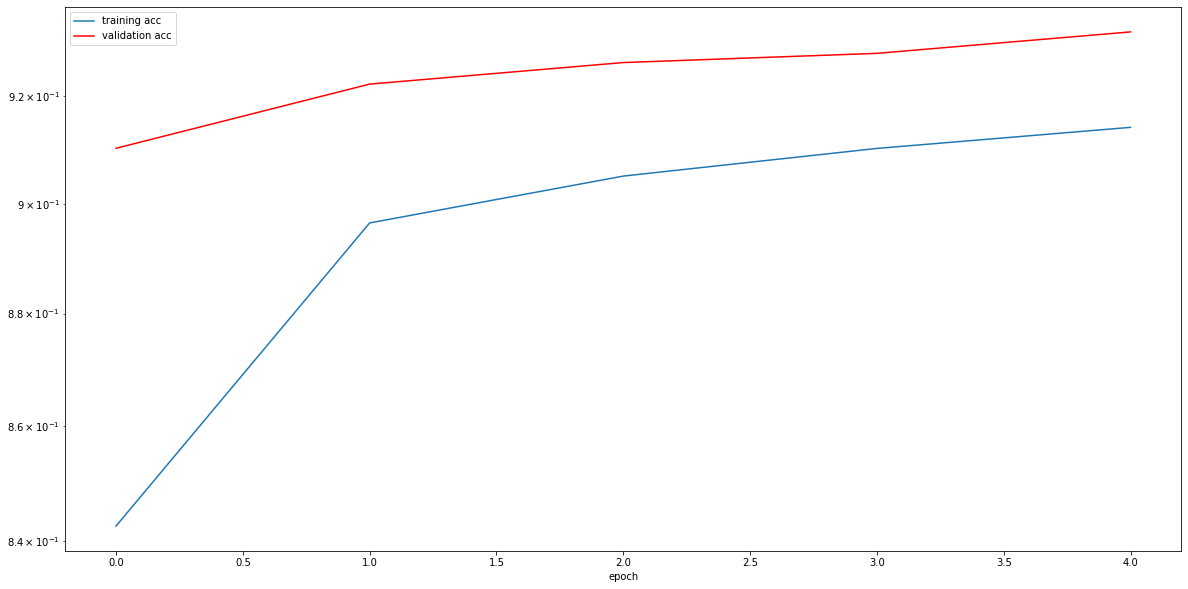

In [9]:
plot_metrics(conf=conf, metric='accuracy')